In [11]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.optimize as sciopt

import pandas as pd
import seaborn as sns

%matplotlib inline

Constants

In [2]:
# 1D EDO for Fold bifurcation paramaters
a1 = -1
a2 = 1

# 2D EDO for Hopf bifurcation parameters
b1 = b2 = 1
c1 = -1
c2 = 1

# coupling parameters
gamma1 = -0.1
gamma2 = 0.12

TRESHOLD = 10**-4

ODEs

In [3]:
import numpy as np

# linear coupling parameter
# proposed by Dekker et al. article
def gamma(x):
  return gamma1 + (gamma2 * x)

"""
  :x: float
"""
def fold(x, phi):
  return (a1 * (x ** 3)) + (a2 * x) + phi

def fold_df(x, phi):
  return (3 * a1 * (x ** 2)) + a2

"""
  :r: float
"""
def hopf_polar(r, gam):
  return (gam * r) - (r ** 3)

def hopf_polar_df(r, gam):
  return gam - (3 * (r ** 2))

"""
  :r: float
"""
def hopf_polar_coupled(r, x):
  return (gamma(x) * r) - (r ** 3)

def hopf_polar_coupled_df(r, x):
  return gamma(x) - (3 * (r ** 2))


# v is a vector \vec{v}: [x, y, z]
def fold_hopf(v, phi):
  return np.array([
    a1 * (v[0] ** 3) + a2 * v[0] + phi,
    b1*v[2] + b2*(gamma(v[0]) - (v[1]**2 + v[2]**2))*v[1],
    c1*v[1] + c2*(gamma(v[0]) - (v[1]**2 + v[2]**2))*v[2]
  ])

l = [[1, 2], [3, 4]]
l
list(zip(*sorted(l, key=lambda x: x[0])))

[(1, 3), (2, 4)]

Bifurcations

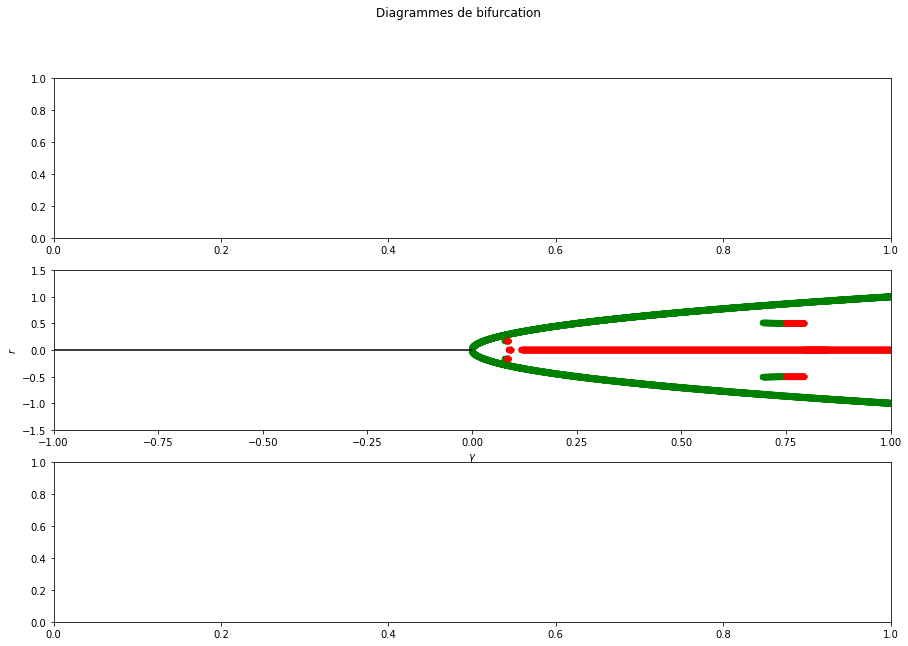

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10))
fig.suptitle("Diagrammes de bifurcation")

"""Leading vs forcing \phi

"""
def fold_bifurcation(fx, df):
  stable_equ_up = []
  stable_equ_down = []
  unstable_equ = []
  
  nphi = 1000
  nx = 10000
  
  phi_mesh = np.linspace(start=-1, stop=1, num=nphi)
  x_mesh = np.linspace(start=-1.5, stop=1.5, num=nx)
  
  # algorithm
  for phi in phi_mesh:
    for x in x_mesh:
      f_value = fx(x, phi)
      #print(f_value)
      # check if I am in trusting interval (i.e. near an equilibirum point such that \dot{r} = 0)
      if - TRESHOLD < f_value < TRESHOLD:
        # YEAH ! We hit an equilibrium point. 
        # Check its stability (stable or unstable)
        df_value = df(x, phi)
        if df_value > 0:
          unstable_equ.append([phi, x])
        elif df_value < 0:
          if x > 0.:  
            stable_equ_up.append([phi, x])
          elif x < 0.: 
            stable_equ_down.append([phi, x])
  
  # [[x1, phi1],...,[xN, phiN]] => [[x1,...,xN], [phi1,...,phiN]]
  unstable_equ = list(zip(*unstable_equ))
  stable_equ_up = list(zip(*stable_equ_up))
  stable_equ_down = list(zip(*stable_equ_down))
  
  # plot
  ax1.plot(stable_equ_up[0], stable_equ_up[1], color="black", label="ligne stable")
  ax1.plot(stable_equ_down[0], stable_equ_down[1], color="black", label="ligne stable")
  ax1.plot(unstable_equ[0], unstable_equ[1], linestyle="dashdot", color="red", label="ligne instable")
  ax1.set_xlabel("$\phi$")
  ax1.set_ylabel("$x$")
  ax1.set_xlim(-1, 1)
  ax1.set_ylim(-1.5, 1.5)
  ax1.set_title("Fold")
  ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

"""Following vs coupling \gamma

"""
def hopf_bifurcation(fx, df, ax):
  stable_equ_middle = []
  stable_equ_up = []
  stable_equ_down = []
  unstable_equ = []

  ngamma = 1000
  nr = 10
  
  r_min = -1.5
  r_max = 1.5
  
  ntries = 10

  gamma_mesh = np.linspace(start=-1, stop=1, num=ngamma)
  r_mesh = np.linspace(start=r_min, stop=r_max, num=nr)

  # algorithm
  # start from r_min as guess
  guess = r_min
  for gamma in gamma_mesh:  
    # look for some roots. 
    for r in r_mesh:
      sol = sciopt.root(fun=fx, jac=df, x0=r, method="hybr", tol=0.01, args=(gamma))
      root = sol.x[0]
      guess = root
      #print(root)
      # Check its stability (stable or unstable)
      df_value = df(root, gamma)
      if df_value > 0:
        unstable_equ.append([gamma, root])
      elif df_value < 0:
        # decorralate points (otherwise matplotlib connect every points of each branch with a line)
        if root > 0.:
          stable_equ_up.append([gamma, root])
        elif root < 0.:
          stable_equ_down.append([gamma, root])
        else:
          #print([gamma, r])
          stable_equ_middle.append([gamma, root])

  unstable_equ = list(zip(*unstable_equ))
  stable_equ_middle = list(zip(*stable_equ_middle))
  stable_equ_up = list(zip(*stable_equ_up))
  stable_equ_down = list(zip(*stable_equ_down))
  


  # plot
  ax2.plot(stable_equ_middle[0], stable_equ_middle[1], color="black", label="ligne stable")
  ax2.scatter(stable_equ_up[0], stable_equ_up[1], linestyle="dashdot", color="green", label="ligne stable - osc.")
  ax2.scatter(stable_equ_down[0], stable_equ_down[1], linestyle="dashdot", color="green", label="ligne stable - osc.")
  ax2.scatter(unstable_equ[0], unstable_equ[1], linestyle="dashdot", color="red", label="ligne instable")
  ax2.set_xlabel("$\gamma$")
  ax2.set_ylabel("$r$")
  ax2.set_xlim(-1, 1)
  ax2.set_ylim(-1.5, 1.5)

"""Following vs forcing \phi
  # 1. loop each \phi
  # # 1.1. solve \dot{x} for that \phi => get x value
  # # 1.2. loop each r
  # # # 1.2.1 check root of the "following system" (polar)
  # # # 1.2.1 that value of x will change value of \gamma in the "following system"
"""
def fold_hopf_bifurcations(fx, df):
  pass

def run_bifurcations():
  #fold_bifurcation(fold, fold_df)
  hopf_bifurcation(hopf_polar, hopf_polar_df, ax2)
  
run_bifurcations()

In [5]:
# initial conditions
x0 = -0.5
y0 = 1.0
z0 = -1.0

r0 = 5.0

# time range
t_init = 0
t_fin = 500
time_step = 0.01

# gaussian noise parameters
mean = 0.0
variance = 0.1

# parameters for stochastic plot
a1_stoch = -1
a2_stoch = 1
b1_stoch = 0.1
b2_stoch = 1
c1_stoch = -0.5
c2_stoch = 1
gamma1_stoch = -0.2
gamma2_stoch = 0.3
time_step_stoch = 0.1

In [6]:
# v is a vector \vec{v}: [x, y, z]
def fold_hopf(v, phi):
  return np.array([
    a1 * (v[0] ** 3) + a2 * v[0] + phi,
    b1*v[2] + b2*(gamma(v[0]) - (v[1]**2 + v[2]**2))*v[1],
    c1*v[1] + c2*(gamma(v[0]) - (v[1]**2 + v[2]**2))*v[2]
  ])

def fold_hopf_stoch(v, phi):
  #print(v, phi)
  return np.array([
    a1_stoch * (v[0] ** 3) + a2_stoch * v[0] + phi,
    b1_stoch * v[2] + b2_stoch * (gamma(v[0]) - (v[1]**2 + v[2]**2))*v[1],
    c1_stoch * v[1] + c2_stoch * (gamma(v[0]) - (v[1]**2 + v[2]**2))*v[2]
  ])

Runge-Kutta 4

In [6]:
def rk4_derivatives(edo, v, dt, *args):
  k1 = edo(v, *args)
  k2 = edo(v + ((dt / 2) * k1), *args)
  k3 = edo(v + ((dt / 2) * k2), *args)
  k4 = edo(v + (dt * k3), *args)
  return (k1 + 2*k2 + 2*k3 + k4)

def rk4(edo, v, dt, *args):
  return (dt / 6) * rk4_derivatives(edo, v, dt, *args)

In [8]:
"""
forward euler method with a stochastical term
x_{i+1} = x_i * dt + zeta + sqrt(dt)
(forward-euler + gaussian noise * sqrt(dt))
"""
def forward_euler_maruyama(edo, v, dt, *args):
  zeta = np.random.normal(loc=mean, scale=np.sqrt(variance))
  return edo(v, *args) * dt + zeta * np.sqrt(dt)

Time series

In [ ]:
class time_series():
  def __init__(self):
    # initial conditions
    self.initial_conditions = np.array([[x0, y0, z0]])
    # forcing parameter
    self.phi = -2
    # time
    self.t0 = t_init
    self.tN = t_fin
    # stochastic number of iterations
    self.niter = 100
    # legend
    self.legends = ["$x$ (leading)", "$y$ (following)", "$z$ (following)"]

  """ Plot a temporal serie

  :solver: function -- (edo, v, dt, *args) -> ndarray
  :edo: function -- (v, phi) -> ndarray
  :dt: float -- time step
  :nt: int -- number of time steps (N)

  :return: ndarray -- [[x0, y0, z0], ..., [x{N-1}, y{N-1}, z{N-1}]]
  """
  def solve(self, solver, edo, dt, nt):
    # [x0, y0, z0]
    #v = self.initial_conditions[0]

    # vector mesh -- will receive the result
    v_mesh = np.ones((nt, 3)) #
    # set inital conditions
    v_mesh[0] = self.initial_conditions[0]
    #print(edo, dt)

    for t in range(0, nt - 1):
      v_mesh[t + 1] = v_mesh[t] + solver(edo, v_mesh[t], dt, self.phi)

      # increase forcing parameter
      if self.phi <= 50.0: self.phi += 0.001

    # reset forcing parameter
    self.phi = -2
    return v_mesh

  def basic(self):
    dt = time_step
    nt = int((self.tN - self.t0) / dt)
    time_mesh_basic = np.linspace(start=self.t0, stop=self.tN, num=nt)

    # [ [x0, y0, z0], [x1, y1, z1], ..., [xN, yN, zN] ]
    results = self.solve(rk4, fold_hopf, dt, nt)
    return time_mesh_basic, results

  def stochastic(self):
    dt = time_step_stoch
    nt = int((self.tN - self.t0) / dt)
    time_mesh_stoch = np.linspace(start=self.t0, stop=self.tN, num=nt)
    reshaped_time_mesh_stoch = np.reshape(time_mesh_stoch, (1, -1))

    results = np.ones((3, nt))
    stochastic_results = np.ones((self.niter, nt, 4))
    # compute a lot of simulations
    for i in range(0, self.niter):
      results = self.solve(forward_euler_maruyama, fold_hopf_stoch, dt, nt)
      # concatenate (x, y, z) columns with (t) column
      results = np.concatenate((reshaped_time_mesh_stoch.T, results), axis=1)
      stochastic_results[i] = results

    # compute the mean
    # mean = np.mean(stochastic_results, axis=0)

    # data transformation for data visualisation
    # stack all the (t, x, y, z) column vectors of all the simulations
    stacked_stochastic_results = np.reshape(stochastic_results, (-1, 4))

    # create panda dataframe from it
    df_stochastic = pd.DataFrame(data=stacked_stochastic_results, columns=["t", "x", "y", "z"])

    # aggregate x, y, z
    df_stochastic = df_stochastic.reset_index()[["t", "x", "y", "z"]].melt(
      id_vars="t",
      value_vars=("x", "y", "z"),
      var_name="position",
      value_name="variables"
    )

    return time_mesh_stoch, df_stochastic

  def plot(self):
    time_mesh_basic, basic_results = self.basic()
    time_mesh_stoch, stochastic_results = self.stochastic()

    # 2 lines, 1 column
    fig, ((ax1), (ax2)) = plt.subplots(2, 1, figsize=(15, 7))
    fig.suptitle("Série temporelle")

    ax1.plot(time_mesh_basic, basic_results[:,0], color="black")
    ax1.plot(time_mesh_basic, basic_results[:,1], color="red")
    ax1.plot(time_mesh_basic, basic_results[:,2], color="gold")

    ax1.set_xlabel("$t$")
    ax1.set_ylabel("$x$, $y$, $z$")
    ax1.set_xlim(0,500)
    ax1.set_ylim(-7,7)
    ax1.legend(self.legends, loc="center left", bbox_to_anchor=(1,0.5))
    ax1.set_title("Basique")

    # ax2.plot(time_mesh_stoch, stochastic_results[:,0], color="black")
    # ax2.plot(time_mesh_stoch, stochastic_results[:,1], color="red")
    # ax2.plot(time_mesh_stoch, stochastic_results[:,2], color="gold")

    # plot the mean of all the simulations
    # with a 95% CI interval
    # print(stochastic_results.head())
    g = sns.lineplot(
      x="t",
      y="variables",
      hue="position",
      palette=("red", "gold", "black"),
      data=stochastic_results,
      ax=ax2
    )

    ax2.set_xlabel("$t$")
    ax2.set_ylabel("$x$, $y$, $z$")
    ax2.set_xlim(0,500)
    ax2.set_ylim(-5,5)
    ax2.legend(self.legends, loc="center left", bbox_to_anchor=(1,0.5))
    ax2.set_title("Stochastique")

    plt.tight_layout()
    plt.show()


def run_time_series():
  time_serie = time_series()
  time_serie.plot()
    
run_time_series()

In [ ]:
def hopf(y, z, gam):
  return np.array([
    b1*z + b2*(gam - (y**2 + z**2))*y,
    c1*y + c2*(gam - (y**2 + z**2))*z
  ])

def solve(solver, edo, initial, dt, nt, *args):
  # vector mesh -- will receive the result
  v_mesh = np.ones((nt, 3)) #
  # set inital conditions
  v_mesh[0] = initial

  for t in range(0, nt - 1):
    v_mesh[t + 1] = v_mesh[t] + solver(edo, v_mesh[t], dt, gam)

  return v_mesh

def phase_plot():
  dt = time_step
  nt = int((t_fin - t_init) / dt)
  gam = 1.
  
  initial = [x0, y0, z0]
  
  time_mesh = np.linspace(start=t_init, stop=t_fin, num=nt)
  
  y_mesh = np.linspace(start=-3, stop=3, num=nt)
  z_mesh = np.linspace(start=-3, stop=3, num=nt)
  
  # meshgrid useful to evaluate function on a grid
  Y, Z = np.meshgrid(y_mesh, z_mesh)
  print(Y, Z)
  
  f = hopf(Y, Z, gam)
  print(f)
  plt.streamplot(Y, Z, f[0,:], f[1,:], color="#BBBBBB")
  
  results = solve(rk4, hopf, initial, dt, nt, gam)
  plt.plot(results[0,:], results[1,:], 'blue')
  plt.title("Portrait de Phase - Hopf Bifurcation")
  plt.xlabel('x')
  plt.ylabel('y')
  
phase_plot()